#  <center> Problem Set 4 <center>
<center> Spring 2021 <center>
<center> 3.100/3.322, 10.402/10.602, 20.301/20.401 <center>
<center> Due:10 pm ET on Thursday, Apr 22, 2021 <center>

## Part 1. Graph Convolutional Nets 

### 1.1 Install and try out RDkit

First, request a GPU by going to Edit/Notebook Settings/Hardware Accelerator.

In [1]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [2]:
# This is a hack to install RDkit without needing to install conda which might take minutes.
# If you have Anaconda installed, you can install rdkit from Anaconda:
#     conda install rdkit -c conda-forge

# url = 'https://anaconda.org/rdkit/rdkit/2018.09.1.0/download/linux-64/rdkit-2018.09.1.0-py36h71b666b_1.tar.bz2'
# !curl -L $url | tar xj lib
# !mv lib/python3.6/site-packages/rdkit /usr/local/lib/python3.7/dist-packages/

# x86 = '/usr/lib/x86_64-linux-gnu'
# !mv lib/*.so.* $x86/
# !ln -s $x86/libboost_python3-py36.so.1.65.1 $x86/libboost_python3.so.1.65.1

In [1]:
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import Descriptors,Crippen
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import sys
import torch 
from tqdm import tqdm
import itertools

from rdkit import RDLogger   
RDLogger.DisableLog('rdApp.*') # turn off RDKit warning message 

In [53]:
# Optional: mount your google drive to save model and files 

# from google.colab import drive
# drive.mount('/content/drive')
# mydrive = '/content/drive/MyDrive'

The following example creates **dopamine** and **caffeine** from a SMILES string.

In [54]:
# make a mol object 
dopamine_mol = Chem.MolFromSmiles("C1=CC(=C(C=C1CCN)O)O") # Dopamine 
caffeine_mol = Chem.MolFromSmiles("CN1C=NC2=C1C(=O)N(C(=O)N2C)C") # Caffeine 

Create four more molecules from their SMILES string.

In [55]:
################ Code #################

lsd_mol = Chem.MolFromSmiles("CCN(CC)C(=O)C1CN(C2CC3=CNC4=CC=CC(=C34)C2=C1)C")
cocaine_mol = Chem.MolFromSmiles("CN1C2CCC1C(C(C2)OC(=O)C3=CC=CC=C3)C(=O)OC")
acetaminophen_mol = Chem.MolFromSmiles("CC(=O)Nc1ccc(cc1)O")
ibuprofen_mol = Chem.MolFromSmiles("CC(C)CC1=CC=C(C=C1)C(C)C(=O)O")
pethidine_mol = Chem.MolFromSmiles("CCOC(=O)C1(CCN(CC1)C)C2=CC=CC=C2")
delta9_thc_mol = Chem.MolFromSmiles("CCCCCC1=CC(=C2C3C=C(CCC3C(OC2=C1)(C)C)C)O")

################ Code #################

Visualize the molecules using RDkit.

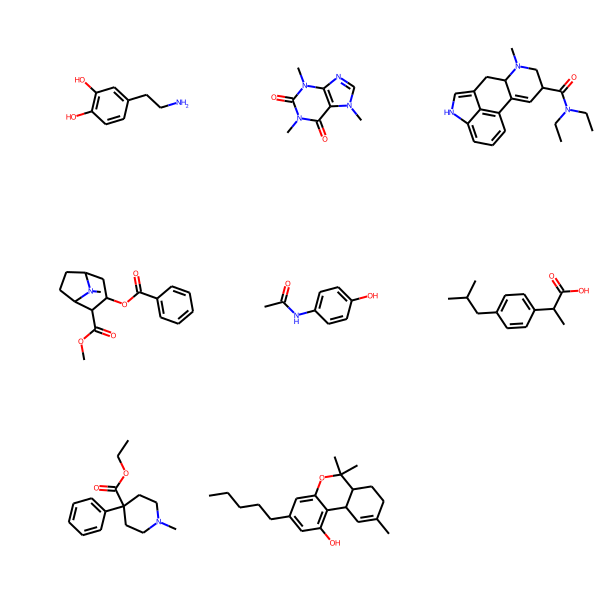

In [56]:
################ Code #################

Draw.MolsToGridImage([
    dopamine_mol,
    caffeine_mol,
    lsd_mol,
    cocaine_mol,
    acetaminophen_mol,
    ibuprofen_mol,
    pethidine_mol,
    delta9_thc_mol
])

################ Code #################

### 1.2 Construct molecular graph datasets and dataloader

#### Download data

Download the data.

In [57]:
# !wget https://raw.githubusercontent.com/wwang2/ML4MolEng/master/psets/ps4/data/qm9.csv

Helper functions and classes.

In [2]:
# implement SMILES to graph function  
def smiles2graph(smiles):
    """
    Transfrom smiles into a list nodes (atomic number)
    
    Args: 
        smiles (str): SMILES strings
    
    Return: 
        z(np.array), A (np.array): list of atomic numbers, adjacency matrix 
    """
    
    mol = Chem.MolFromSmiles(smiles) # no hydrogen 
    z = np.array([atom.GetAtomicNum() for atom in mol.GetAtoms()])
    A = np.stack(Chem.GetAdjacencyMatrix(mol))
    
    return z, A

In [3]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self,
                 AtomicNum_list,
                 Edge_list,
                 Natom_list,
                 y_list):
        """
        Represents a dataset of molecular graphs.
        
        Args: 
            z_list (list of torch.LongTensor)
            a_list (list of torch.LongTensor)
            N_list (list of int)
            y_list (list of torch.FloatTensor)
        """
        self.AtomicNum_list = AtomicNum_list # atomic number
        self.Edge_list = Edge_list           # edge list 
        self.Natom_list = Natom_list         # Number of atoms 
        self.y_list = y_list                 # properties to predict 

    def __len__(self):
        return len(self.Natom_list)

    def __getitem__(self, idx):
        AtomicNum = torch.LongTensor(self.AtomicNum_list[idx])
        Edge = torch.LongTensor(self.Edge_list[idx])
        Natom = self.Natom_list[idx]
        y = torch.Tensor(self.y_list[idx])
        
        return AtomicNum, Edge, Natom, y

In [4]:
def collate_graphs(batch):
    """
    Batch multiple graphs into one batched graph.
    
    Args:
        batch (tuple): tuples of AtomicNum, Edge, Natom and y obtained from
            GraphDataset.__getitem__() 
        
    Return 
        (tuple): Batched AtomicNum, Edge, Natom, y
    """
    
    AtomicNum_batch = []
    Edge_batch = []
    Natom_batch = []
    y_batch = []

    cumulative_atoms = np.cumsum([0] + [b[2] for b in batch])[:-1]
    
    for i in range(len(batch)):
        z, a, N, y = batch[i]
        index_shift = cumulative_atoms[i]
        a = a + index_shift
        AtomicNum_batch.append(z) 
        Edge_batch.append(a)
        Natom_batch.append(N)
        y_batch.append(y)
        
    AtomicNum_batch = torch.cat(AtomicNum_batch)
    Edge_batch = torch.cat(Edge_batch, dim=1)
    # edit: should NOT be sum
    Natom_batch = Natom_batch
    y_batch = torch.cat(y_batch)
    
    return AtomicNum_batch, Edge_batch, Natom_batch, y_batch 

Example usage of `collate_graph`.

In [5]:
# define graph 1 
AtomicNum1 = torch.LongTensor([6, 6, 7])
Edge1  = torch.LongTensor([
    [0, 2, 2, 1],
    [2, 0, 1, 2]
    ])
Natom1 = 3
y1     = torch.Tensor([74.18])

# define graph 2 
AtomicNum2 = torch.LongTensor([6, 6, 8])
Edge2  = torch.LongTensor([
    [0, 2, 2, 1], 
    [2, 0, 1, 2]
    ])
Natom2 = 3
y2     = torch.Tensor([64.32])

graph1 = (AtomicNum1, Edge1, Natom1, y1)
graph2 = (AtomicNum2, Edge2, Natom2, y2)

collate_graphs((graph1, graph2))  

(tensor([6, 6, 7, 6, 6, 8]),
 tensor([[0, 2, 2, 1, 3, 5, 5, 4],
         [2, 0, 1, 2, 5, 3, 4, 5]]),
 [3, 3],
 tensor([74.1800, 64.3200]))

**a.** Write the code to make lists of data for molecular graphs.

In [6]:
import torch
from sklearn.utils import shuffle

df = pd.read_csv("./data/qm9.csv", index_col=0)
df = shuffle(df).reset_index()

In [63]:
df

,index,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,122010,CCCCC(O)CCO,5.48303,0.47805,0.45555,0.2240,86.82,-0.2578,0.0707,0.3286,...,0.226290,-426.630338,-426.618345,-426.617401,-426.668734,42.187,-2239.835645,-2254.528140,-2268.755024,-2074.305673
1,115962,OCC1CCC2OCC12,3.12069,1.20375,0.99813,2.0382,77.44,-0.2422,0.0736,0.3158,...,0.184205,-424.216846,-424.208401,-424.207457,-424.250080,32.355,-1981.050933,-1994.415620,-2006.270520,-1839.023684
2,75003,CC1=CC2OCC3C1C23,3.04917,1.62349,1.45984,1.8466,78.78,-0.2221,0.0127,0.2347,...,0.161837,-385.890038,-385.882967,-385.882022,-385.921240,29.000,-1912.994444,-1925.444851,-1936.113131,-1783.319082
3,88995,CC1CN1CC1CCC1,4.10341,0.79824,0.73379,1.0590,90.53,-0.2196,0.0904,0.3100,...,0.217449,-368.372929,-368.363277,-368.362333,-368.408177,36.291,-2203.056715,-2218.330284,-2231.964172,-2042.440766
4,9927,C#CC1(O)C(C)C1C,3.06292,1.52537,1.38491,1.1091,75.75,-0.2338,0.0355,0.2693,...,0.150355,-347.758724,-347.749304,-347.748360,-347.792110,34.666,-1734.441779,-1744.528986,-1754.605525,-1615.264014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133880,115326,O=C1C(O)COC1CO,2.98164,1.20453,0.95553,1.3470,64.48,-0.2599,-0.0473,0.2125,...,0.135052,-496.104385,-496.095649,-496.094705,-496.138222,31.991,-1637.814178,-1647.440793,-1656.923709,-1522.395192
133881,121862,CC(=O)C(O)CCCO,3.65159,0.64491,0.57657,3.6601,76.49,-0.2650,-0.0268,0.2382,...,0.178970,-461.379659,-461.368548,-461.367604,-461.417116,38.624,-1946.541703,-1958.232823,-1970.087723,-1806.908400
133882,55896,CC(=O)CC1CN1C=O,3.71746,0.86476,0.74451,5.2308,74.81,-0.2488,-0.0233,0.2255,...,0.144589,-439.101369,-439.091583,-439.090639,-439.137728,33.588,-1760.326525,-1770.183436,-1780.259348,-1640.008577
133883,96779,CN=C1C(=O)CC2CN12,2.80313,1.56370,1.08709,2.5741,77.44,-0.2260,-0.0732,0.1528,...,0.135585,-417.999002,-417.990718,-417.989773,-418.032842,30.393,-1684.161992,-1694.072870,-1703.555158,-1568.896747


In [7]:
################ Code #################

atomic_num_list = []
edge_list = []
y_list = []
natom_list = []

for row in df.itertuples():
    smiles = row.smiles
    atoms, adj = smiles2graph(smiles)
    edges = torch.LongTensor(np.array(np.nonzero(adj)))
    natom = len(atoms)
    alpha = row.alpha
    
    atomic_num_list.append(atoms)
    edge_list.append(edges)
    # note we're adding a list; this is needed to convert it to a Tensor.
    # see the example above for collate_graph
    y_list.append([alpha])
    natom_list.append(natom)
    
################ Code #################

**b.** Write the code that will make train, validation, test datasets and dataloaders.

In [23]:
################ Code #################

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# notice how order changes; y_list is last
data = list(zip(atomic_num_list, edge_list, natom_list, y_list))

data_train_val, data_test = train_test_split(
    data,
    test_size=0.2,
    shuffle=True,
    random_state=54321
    )
data_train, data_val = train_test_split(
    data_train_val,
    train_size=7/8,
    shuffle=False
    )

graphs_train = GraphDataset(*list(zip(*data_train)))
graphs_val = GraphDataset(*list(zip(*data_val)))
graphs_test = GraphDataset(*list(zip(*data_test)))

train_loader = DataLoader(graphs_train, batch_size=512, shuffle=False, collate_fn=collate_graphs)
val_loader = DataLoader(graphs_val, batch_size=512, shuffle=False, collate_fn=collate_graphs)
test_loader = DataLoader(graphs_test, batch_size=512, shuffle=False, collate_fn=collate_graphs)

################ Code #################

In [66]:
graphs_train[0]

(tensor([8, 6, 7, 6, 6, 8, 6, 6, 6]),
 tensor([[0, 1, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 8],
         [1, 0, 2, 8, 1, 3, 2, 4, 3, 5, 8, 4, 6, 5, 7, 6, 8, 1, 4, 7]]),
 9,
 tensor([72.3900]))

### 1.3 Complete the definition of a GNN

In [11]:
from itertools import repeat

def scatter_add(src, index, dim_size, dim=-1, fill_value=0):
    """
    Sums all values from the src tensor into out at the indices specified in the index 
    tensor along a given axis dim. 
    """
    
    # make index the same shape as src
    # this will make `scatter_add_` add vectors from `src` to `out`
    index_size = list(repeat(1, src.dim()))
    index_size[dim] = src.size(dim)
    index = index.view(index_size).expand_as(src)
    
    # create the shape of the out vector
    # out will have shape src.size() but with `dim` changed to dim_size
    # e.g.
    #    - src contains 1 row vector for each edge,
    #    - out's rows should have the same dim as those vectors,
    #      but the number of rows should be the number of nodes,
    #      not the number of edges
    dim = range(src.dim())[dim] # convert -1 to actual dim number
    out_size = list(src.size())
    out_size[dim] = dim_size

    out = src.new_full(out_size, fill_value)

    return out.scatter_add_(dim, index, src)

In [12]:
message_i2j = torch.Tensor(
    [[1000., 500., 250., 125.],
     [ 100.,  50.,  25., 12.5],
     [  10.,   5.,  2.5, 1.25]])  # 3 x 4

Edge = torch.LongTensor(
    [[0, 0, 3],
     [1, 2, 4]])      # 2 x 3 (always 2 x something)

node_message = scatter_add(
    src=message_i2j,
    index=Edge[1],
    dim=0,
    dim_size=6       # 4 x 6
    ) 

print(node_message)

tensor([[   0.0000,    0.0000,    0.0000,    0.0000],
        [1000.0000,  500.0000,  250.0000,  125.0000],
        [ 100.0000,   50.0000,   25.0000,   12.5000],
        [   0.0000,    0.0000,    0.0000,    0.0000],
        [  10.0000,    5.0000,    2.5000,    1.2500],
        [   0.0000,    0.0000,    0.0000,    0.0000]])


#### Example usage for `scatter_add()` and `torch.split()`

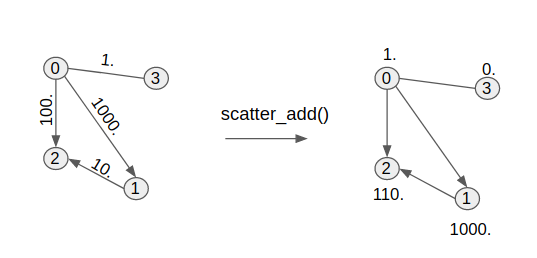

In [13]:
# scatter_add() exmaple usage 1 

# Say you have a graph with 4 nodes, and there are an edge list that describes their connectivities  

Edge = torch.LongTensor([[0, 0, 1, 3], # index for i 
                         [1, 2, 2, 0]]) # index for j 

# It means that the 0th node is connected to 1st node and the 2nd node; the 1st node is
#    connected to the 2nd node. 
# For now, let us assume the connections are directed, i.e. 0th node is connected the 1st
#    node, but the 1st node is not connected to the 0th node. 
# We want pass connection messages from the nodes in the first row to the nodes in the
#    second row in Edge.

# And for each edge, we have an message we want to broadcast from i to j 
message_i2j = torch.Tensor([1000., 100., 10., 1.])

# We can use scatter_add() function to aggregate these pairwise messages onto each node. 

node_message = scatter_add(src=message_i2j, # message array for all the directed edge 
            index=Edge[1], # index to all the jth node to which you want to pass your message 
            dim=0,         # feature dimension you want to sum over 
            dim_size=4     # there are 4 nodes 
            ) 

print(node_message)


tensor([   1., 1000.,  110.,    0.])


In [70]:
# Now you can look at your results, you can see the messages are assigned from message_i2j to all the jth nodes you specified

# If you want your graph to be undirected, i.e. the ith node is connected to the jth node and vice versa, you can perfrom the summation in both direction like this: 
node_message = scatter_add(src=message_i2j, index=Edge[1], dim=0, dim_size=4) +  scatter_add(src=message_i2j, index=Edge[0], dim=0, dim_size=4)

print(node_message)

tensor([1.1010e+03, 1.0100e+03, 1.1000e+02, 1.0000e+00])


In [71]:
# torch.split() example usage 
tensor = torch.LongTensor(range(10)).view(5, 2)
splits_idx = [2, 3] # list of integers 
print(torch.split(tensor, splits_idx)) 

# you have two tensors with size (2,2) and (3,2) respectively 
for split in torch.split(tensor, splits_idx):
    print(split.shape)

(tensor([[0, 1],
        [2, 3]]), tensor([[4, 5],
        [6, 7],
        [8, 9]]))
torch.Size([2, 2])
torch.Size([3, 2])


In [72]:
# And you can sum the split array separately and stack them together 
print(torch.stack([split.sum(0) for split in torch.split(tensor, splits_idx)], dim=0))

tensor([[ 2,  4],
        [18, 21]])


In [28]:
from torch import nn
from torch.nn import ModuleDict

class GNN(nn.Module):
    """
    A GNN model.
    """
    def __init__(self, n_convs=3, n_embed=64):
        super(GNN, self).__init__()
        
        self.atom_embed = nn.Embedding(100, n_embed)
        # Declare MLPs in a ModuleList
        self.convolutions = nn.ModuleList([ 
                ModuleDict({
                    "update_mlp": nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                nn.ReLU(), 
                                                nn.Linear(n_embed, n_embed)),
                    "message_mlp": nn.Sequential(nn.Linear(n_embed, n_embed), 
                                                 nn.ReLU(), 
                                                 nn.Linear(n_embed, n_embed)) 
                })
                for _ in range(n_convs)
            ])
        # Declare readout layers
        self.readout = nn.Sequential(
            nn.Linear(n_embed, n_embed),
            nn.ReLU(),
            nn.Linear(n_embed, 1)
            )
        
    def forward(self, AtomicNum, Edge, Natom):
        ################ Code #################
        
        # Parameterize embedding 
        h = self.atom_embed(AtomicNum) # shape=(Natom, n_embed)
        
        for conv in self.convolutions:
            prod = h[Edge[0]] * h[Edge[1]]  # shape=(Nedge, n_embed)
            msgs = conv["message_mlp"](prod) # shape=(Nedge, n_embed)
            # send the messages to nodes, undirected graph
            # sum(Natom) is needed because we collated the graph
            agg_msg = scatter_add(src=msgs, index=Edge[1], dim=0, dim_size=sum(Natom)) + \
                      scatter_add(src=msgs, index=Edge[0], dim=0, dim_size=sum(Natom))
            
            # transform the message using UpdateMLP, and add as residual connection
            h += conv["update_mlp"](agg_msg)
        
        readout = self.readout(h)
        # readout for each individual graph in the batch
        readout_split = torch.split(readout, Natom)
        output = torch.stack(
            [split.sum(0) for split in readout_split],
            dim=0
            ).squeeze()
        
        ################ Code #################
        return output

See if your GNN has the correct dimensions.

In [74]:
# node input
AtomicNum_orig = torch.LongTensor([6, 6, 8, 7])
# edge input 
Edge_orig = torch.LongTensor([[0, 0, 1, 2, 3, 0], [1, 2, 0, 0, 0, 3]] )

model = GNN(n_convs=4, n_embed=128)
model(AtomicNum_orig, Edge_orig, [len(AtomicNum_orig)])

tensor([[0.8878]], grad_fn=<StackBackward0>)

### 1.4 Verify that your GNN preserves permutational invariance

In [75]:
def permute_graph(z, a, perm):
    """
    Permutes the order of nodes in a molecular graph.

    Args: 
        z(np.array): atomic number array
        a(np.array): edge index pairs 

    Return: 
        (np.array, np.array): permuted atomic number, and edge list 
    """
    
    z = np.array(z)
    perm = np.array(perm)
    assert len(perm) == len(z)
    
    z_perm = z[perm]
    a_perm = np.zeros(a.shape).astype(int)
    
    for i, edge in enumerate(a):
        for j in range(len(edge)):
            a_perm[i, j] = np.where(perm==edge[j])[0]
    return z_perm, a_perm

# node input
AtomicNum_orig = np.array([6, 6, 8, 7])
# edge input 
Edge_orig = np.array([[0, 0, 1, 2, 3, 0], [1, 2, 0, 0, 0, 3]] )
# generate permutations
permutation = list(itertools.permutations([0, 1, 2, 3]))

Test your model on a permuted graph.

In [76]:
################ Code #################

device = 0
model = GNN(n_convs=4, n_embed=128).to(device)
model.eval()

for perm in permutation:
    z_perm, a_perm = permute_graph(AtomicNum_orig, Edge_orig, perm)
    z_perm = torch.LongTensor(z_perm).to(device)
    a_perm = torch.LongTensor(a_perm).to(device)
    output = model(z_perm, a_perm, [len(z_perm)]).detach().cpu().item()
    print("model output: {:.5f} for permutation: {}".format(output, perm)) 
    
################ Code #################

model output: -0.08857 for permutation: (0, 1, 2, 3)
model output: -0.08857 for permutation: (0, 1, 3, 2)
model output: -0.08857 for permutation: (0, 2, 1, 3)
model output: -0.08857 for permutation: (0, 2, 3, 1)
model output: -0.08857 for permutation: (0, 3, 1, 2)
model output: -0.08857 for permutation: (0, 3, 2, 1)
model output: -0.08857 for permutation: (1, 0, 2, 3)
model output: -0.08857 for permutation: (1, 0, 3, 2)
model output: -0.08857 for permutation: (1, 2, 0, 3)
model output: -0.08857 for permutation: (1, 2, 3, 0)
model output: -0.08857 for permutation: (1, 3, 0, 2)
model output: -0.08857 for permutation: (1, 3, 2, 0)
model output: -0.08857 for permutation: (2, 0, 1, 3)
model output: -0.08857 for permutation: (2, 0, 3, 1)
model output: -0.08857 for permutation: (2, 1, 0, 3)
model output: -0.08857 for permutation: (2, 1, 3, 0)
model output: -0.08857 for permutation: (2, 3, 0, 1)
model output: -0.08857 for permutation: (2, 3, 1, 0)
model output: -0.08857 for permutation: (3, 0,

### 1.5  Train and test your GNN

In [77]:
def loop(model, optimizer, loader, epoch, evaluation=False, device="cpu"):
    if evaluation:
        model.eval()
        mode = "eval"
    else:
        model.train()
        mode = "train"
    batch_losses = []
    
    # Define tqdm progress bar 
    tqdm_data = tqdm(loader, position=0, leave=True, desc="{} (epoch #{})".format(mode, epoch))
    
    for data in tqdm_data:
        AtomicNumber, Edge, Natom, y = data 
        AtomicNumber = AtomicNumber.to(device)
        Edge = Edge.to(device)
        y = y.to(device)
        
        # make predictions 
        pred = model(AtomicNumber, Edge, Natom)
        
        # define loss 
        loss = (pred - y).pow(2).mean()  
        
        if not evaluation:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        batch_losses.append(loss.item())

        postfix = ["batch loss={:.3f}".format(loss.item()) , 
                   "avg. loss={:.3f}".format(np.array(batch_losses).mean())]
        
        tqdm_data.set_postfix_str(" ".join(postfix))
    
    return np.array(batch_losses).mean()

In [33]:
# Train script

# from torch import optim

# device = 0
# model = GNN(n_convs=4, n_embed=128).to(device)

# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=50, verbose=True)

# for epoch in range(500):    
#     train_loss = loop(model, optimizer, train_loader, epoch, device=device)
#     val_loss = loop(model, optimizer, val_loader, epoch, evaluation=True, device=device)
    
#     # save model 
#     if epoch % 20 == 0:
#         torch.save(model.state_dict(), "saved_models_part1/gcn_model_{}.pt".format(epoch))

eval (epoch #57): 100%|███████████████████████████████████████████████| 7/7 [00:00<00:00, 66.94it/s, batch loss=1044.971 avg. loss=297.239]


eval (epoch #115): 100%|███████████████████████████████████████████████| 7/7 [00:00<00:00, 65.14it/s, batch loss=790.112 avg. loss=322.482]


eval (epoch #173): 100%|███████████████████████████████████████████████| 7/7 [00:00<00:00, 64.53it/s, batch loss=637.927 avg. loss=684.260]


train (epoch #188):  17%|███████▊                                     | 8/46 [00:00<00:01, 29.31it/s, batch loss=280.541 avg. loss=148.946]


KeyboardInterrupt: 

Plot a scatter plot (predicted vs. true polarizabilities, training and test set) and losses during training.

In [30]:
import matplotlib.pyplot as plt

def get_predictions(model, loader, device="cpu"):
    model.eval()
    
    total_loss = 0
    total_samples = 0
    preds = []
    truth = []
    
    for data in loader:
        AtomicNumber, Edge, Natom, y = data 
        AtomicNumber = AtomicNumber.to(device)
        Edge = Edge.to(device)
        y = y.to(device)
        total_samples += len(Natom)
        
        pred = model(AtomicNumber, Edge, Natom)
        se = (pred - y).pow(2)
        
        total_loss += se.sum().item()
        
        preds.extend(pred.detach().cpu().numpy())
        truth.extend(y.detach().cpu().numpy())
        break
    
    return total_loss / total_samples, preds, truth

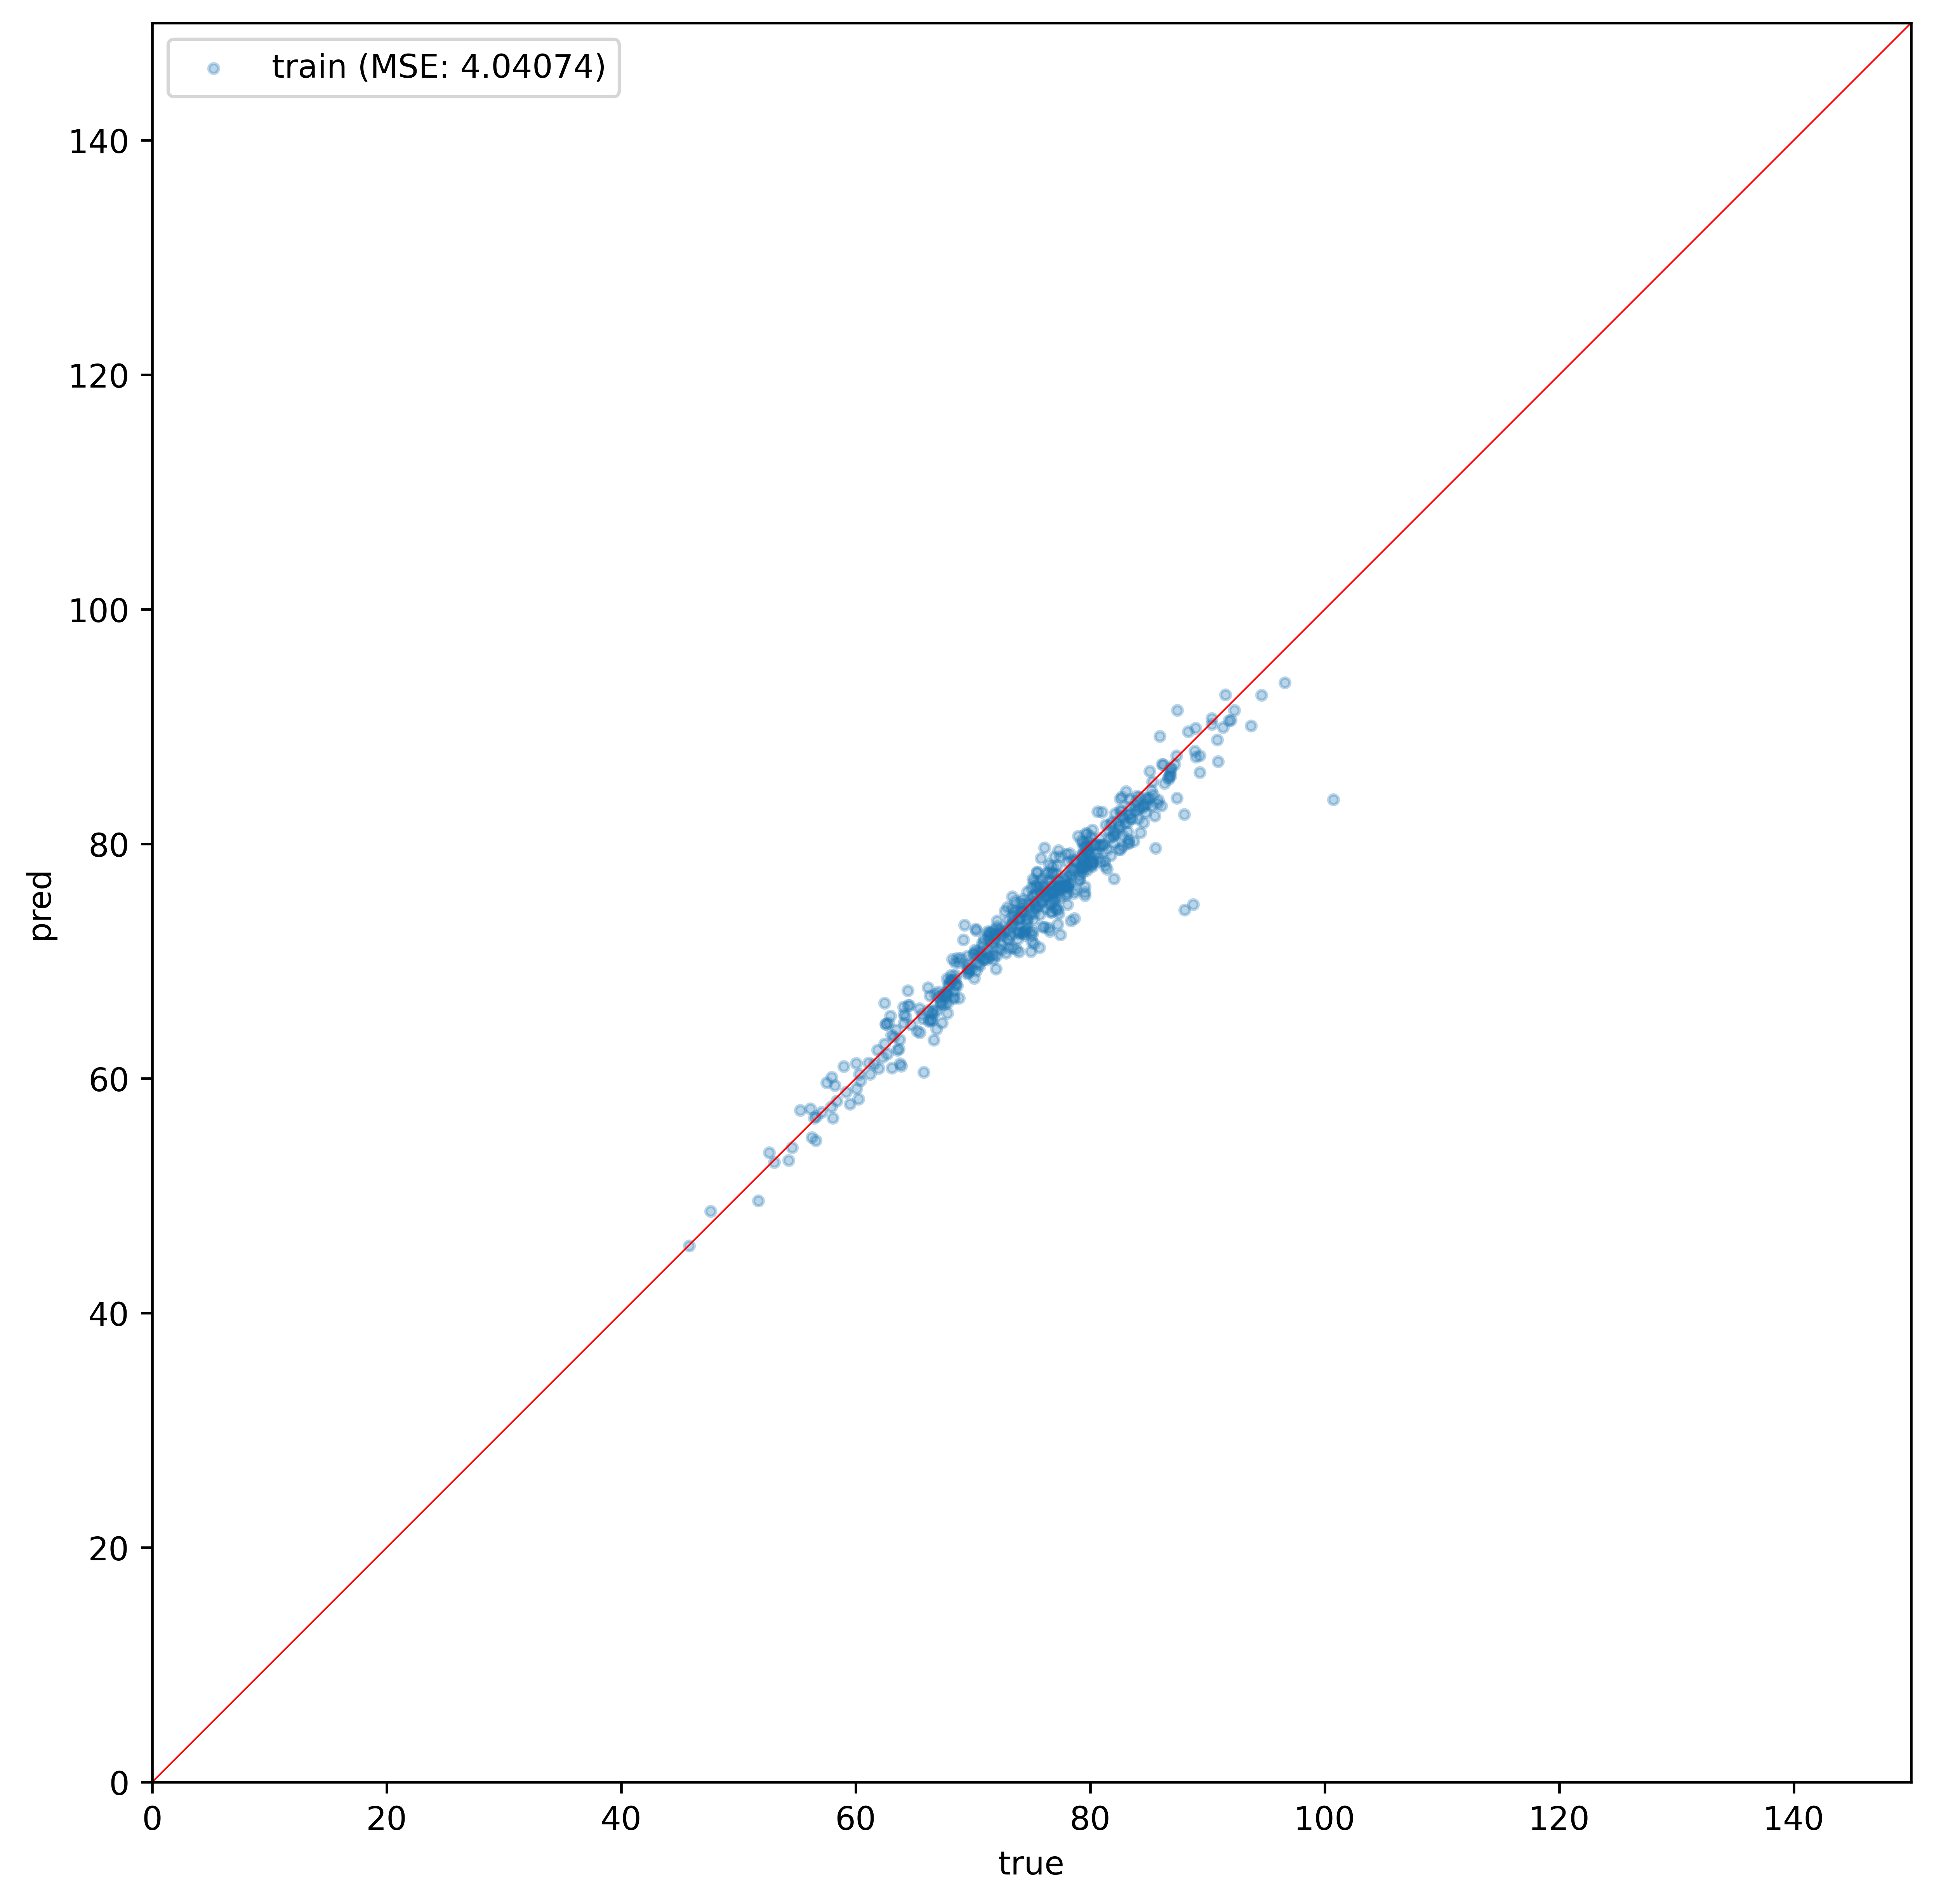

In [31]:
model_file = "./saved_models_part1/gcn_model_300.pt"
model = GNN(n_convs=8, n_embed=256)
model.load_state_dict(torch.load(model_file))
    
device = "cpu"
model.to(device)
train_mse, train_preds, train_truth = get_predictions(model, train_loader, device=device)
# test_mse, test_preds, test_truth = get_predictions(model, test_loader, device=device)

plt.figure(figsize=(10, 10), dpi=600)
plt.plot([0, 150], [0, 150], c="red", lw=0.5)
plt.scatter(train_truth, train_preds, marker=".", alpha=0.3, color="C0", label=f"train (MSE: {train_mse:.5f})")
# plt.scatter(test_truth, test_preds, s=4, alpha=0.2, color="C1", label=f"test (MSE: {test_mse:.5f})")
plt.xlim([0, 150])
plt.ylim([0, 150])
plt.xlabel("true")
plt.ylabel("pred")
plt.legend()
plt.gca().set_aspect("equal")

plt.show()